# Deep Q Learning with the game 2048

This repository trains a q deep learning network from the game 2048 and plots a performance graph. The gamelogic of the game 2048 is based on the implementation from Georg Wiese on his [GitHub Repo](https://github.com/georgwiese/2048-rl) and can for instance be played [here](http://2048game.com/de/). The deep q learning code is loosely based on the implementation form this [GitHub Repo](https://github.com/keon/deep-q-learning) tutorial from keon and was enhanced and adapted to include the game 2048.

## Overview

### Quickstart

To start training, execute all cells. To start plotting the graph, execute all cells of plot.ipynb, located in the root folder DQN-2048.

### The game 2048

2048 is a single-player sliding block puzzle game developed by Gabriele Cirulli in 2014. The game represents a 4 × 4 grid where the value of each cell is a power of 2. An action can be any of the 4 movements: up, down, left right. When an action is performed, all cells move in the chosen direction. Any two adjacent cells with the same value (power of 2) along this direction merge to form one single cell with value equal to the sum of the two cells (i.e. the next power of 2). The objective of the game is to combine cells until reaching 2048. After each move, a new tile appears at a random empty cell. The game is finished until when all cells are full.
TODO: Include example of 2048 move and explain difficulties

The gamelogic of the game 2048 can be found in the folder gamelogic in file game.py.



### Q-Learning

#### Reward
Normally in games, the reward directly relates to the score of the game. The goal of the game is to reach 2048 (although higher scores can be reached), so one option would be to play a game until the score 2048 is reached and then provide a reward. However, the chance to reach a score of 2048 using only random actions is very unlikely. Therefore we implemented rewards depending on the highest tile reached when the game is over.

#### Loss
In order to logically represent this intuition and train it, we need to express this as a formula that we can optimize on. The loss is just a value that indicates how far our prediction is from the actual target. For example, the prediction of the model could indicate that it sees more value in swiping left when in fact it can gain more reward by swiping upwards. We want to decrease this gap between the prediction and the target (loss). The loss is defined as:
TODO: include Loss formula.
In our case this is calculated with this oneliner in the act funtion:

target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))

The repo consists of two parts: the learning part and the full programmed game of 2048.
The gamelogic of the game 2048 can be found in the folder gamelogic in file game.py.

### Libraries

First, we import the libraries and the gamelogic class.

```python
import numpy as np
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import json
import time
from shutil import copyfile
import parameters
import os

from gamelogic.game import Game
```

### Parameters
Next, we define the number of episodes to play. One episode represents one played game and set the hyperparameters.
After each 1000 episodes, the values are being saved in the folder data and can be plotted with the file plot.py.
We implemented an epsilon greedy algorithm with a decay. As you can see, the agent only explores in the beginning and starts decaying with a slow rate of 0.9995.

TODO: why these parameters?

The hyperparameters can be set in the file parameters.py.

The most successful run was achieved using the following configuration:

gamma = 0.00001    # discount rate
epsilon_decay = 0.9995
learning_rate = 0.001
batch_size = 32
is_max_value_reward = True
max_value_reward_threshold = 9
max_value_reward_amount = 100

```python
EPISODES = 100000

path  = os.getcwd()

class DQNAgent:
    def __init__(self):
        self.state_size = 16
        self.action_size = 4 # (up, down, right, left)
        self.memory = deque(maxlen=5000000)
        self.gamma = parameters.gamma    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = parameters.epsilon_decay
        self.learning_rate = parameters.learning_rate
        self.model = self._build_model()
        self.batch_size = parameters.batch_size
        self.is_max_value_reward = parameters.is_max_value_reward
        self.max_value_reward_threshold = parameters.max_value_reward_threshold
        self.max_value_reward_amount = parameters.max_value_reward_amount
        self.output_name = parameters.output_name
```

### Artificial Neural Network

The deep network is a standard artificial neural network consisting of two fully connected hidden layers with 256 nodes each. As activation functions ReLu was used for all layers, which guarantees non vanishing gradients. The loss was computed using the mean squared error (mse). Bigger losses are therefore punished more. As optimizer we used Adam.

Keras does all the work of subtracting the target from the neural network output and squaring it. It also applies the learning rate we defined while creating the neural network model. This all happens inside the fit() function we see later. This function decreases the gap between our prediction to target by the learning rate. The approximation of the Q-value converges to the true Q-value as we repeat the updating process. The loss will decrease and the score will go up.

```python
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(self.action_size, activation='relu'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
```

### Remember

One of the challenges for DQN is that neural network used in the algorithm tends to forget the previous experiences as it overwrites them with new experiences. So we implemented a replay memory, stored as a list of previous experiences and observations to re-train the model with the previous experiences. We will call this array of experiences memory and use the remember() function to append state, action, reward, and next state to the memory.

In our example, the memory list will have a form of:

memory = [(state, action, reward, next_state, done)...]

The remember function will simply store states, actions and resulting rewards to the memory like below:

def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))
done is just a boolean that indicates if the state is the final state.

```python
    def remember(self, state, action, reward, next_state, done):
        """algorithm tends to forget the previous experiences as it overwrites them with new experiences.
        Therefore we re-train the model with previous experiences."""
        self.memory.append((state, action, reward, next_state, done))
```


### Game Step

The act method plays one move of a game. First we implement the epsilon-greedy algorithm and get the four Q-values (which are the output nodes of our neural network) associated with the four possible actions we can do in this move. We then compare these action values with the possible actions, since sometimes we are limited in the actions we can take. We choose the action with the highest Q value that we are allowed to take.

```python
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice(game.available_actions())
        #forward feeding
        act_values = self.model.predict(state)
        #sets q-values of not available actions to -100 so they are not chosen
        if len(game.available_actions())< 4:
          temp = game.available_actions()
          for i in range(0, 4):
            if i not in temp:
              act_values[0][i] = -100
        #returns action with highest q-value
        return np.argmax(act_values[0])
```

### Replay
The replay function trains the neural network with experience from the memory. It first samples a minibatch from the memory. Each memory contains the current state, action, next state and its reward and a boolean done of each state of the minibatch, indicating whether the game is over.
The Q learning algorithm is implemented as:
```python
target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
```
where self.model.predict(next_state)[0] returns the Q-value of the next_state.

```python
self.model.fit(state, target_f, epochs=1, verbose=0)
```
trains one epoch by calculating the loss between the target q value and the predicted q value.
Finally, we apply epsilon decay.


```python
    def replay(self, batch_size):
        """trains the neural net with experiences from memory (minibatches)"""
        #samples mimibatch from memory
        minibatch = random.sample(self.memory, batch_size)
        #for each memory
        for state, action, reward, next_state, done in minibatch:
            #if its final state set target to the reward
            target = reward
            if not done:
                #set target according to formula
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            #gets all 4 predictions from current state
            target_f = self.model.predict(state)
            #takes the one action which was selected in batch
            target_f[0][action] = target
            #trains the model
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

```

### Loading and saving the weights
The weights can be loaded and saved, so training can be interrupted and continued.

```python

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


```

### Putting it all together
The main function loops through the episodes:




```python

    for e in range(EPISODES):
        game.new_game()
        state = game.state()
        state = np.reshape(state, [1, agent.state_size])
```





As long as the game is not over, the act function get's called to receive the calculated action, and the reward gets calculated. If is_max_value_reward is set to TRUE (as in our case) the reward gets calculated by getting the value of the maximum tile. We get this by looking up the highest value from the state variable, which is the playing field containing all tiles represented as a vector. The boolean done checks, whether the game is over and breaks the loop if so, to continue to the next episode:



```python

  while not game.game_over():
            action = agent.act(state)
            reward = (game.do_action(action))**2
            if(agent.is_max_value_reward):
                reward = 0
                temp = game.state()
                temp_reshaped = np.reshape(temp, [1, agent.state_size])
                temp_max_value = np.amax(temp_reshaped[0])
                if temp_max_value > agent.max_value_reward_threshold:
                    reward = agent.max_value_reward_amount
            next_state = game.state()
            actions_available = game.available_actions()
            if len(actions_available) == 0: 
                done = True
            else:
                done = False
            next_state = np.reshape(next_state, [1, agent.state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                if (debug): print("no action available")
                states = game.state()
                states = np.reshape(state, [1, agent.state_size])
                max_value = np.amax(states[0])
                output_list.append([e, np.asscalar(max_value), np.asscalar(game.score()), agent.epsilon])
                if(debug):print("max_value: " + str(max_value))
                break
        print("episodes: " + str(e))
```






For plotting, we save the different parameters into a text file:




```python

        if save_maxvalues:
            if e == 100:
                src = path + "/learn.py"
                dst = path + "/data/"+agent.output_name+"config.py"
                copyfile(src, dst)
                output_list.insert(0, "gamma: "+str(parameters.gamma)+" | epsilon decay: "+str(parameters.epsilon_decay)+" | learning rate: "+str(parameters.learning_rate)+"\n batch size: "+str(parameters.batch_size)+" | reward = maxVal: "+str(parameters.is_max_value_reward)+" | reward amount: "+str(parameters.max_value_reward_amount)+" | reward threshold: "+str(parameters.max_value_reward_threshold))
            if e % 100 == 0:
                with open(path + "/data/"+agent.output_name+"output.txt", "w") as outfile:
                    json.dump(output_list, outfile)

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
        if e % 10000 == 0:
            timenow = time.strftime("%Y-%m-%d_%H-%M-%S")
            savepath = path + "/data/agent"+agent.output_name+timenow+"_Epi"+str(e)
            agent.save(savepath)

```

### Train it
Just execute the following cell. Can be executed at anytime, since values are being stored for plotting.

In [25]:
# -*- coding: utf-8 -*-
import numpy as np
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import json
from gamelogic.game import Game
import time
from shutil import copyfile
import parameters
import os

EPISODES = 100000

path  = os.getcwd()

class DQNAgent:
    def __init__(self):
        self.state_size = 16
        self.action_size = 4 # (up, down, right, left)
        self.memory = deque(maxlen=5000000)
        self.gamma = parameters.gamma    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = parameters.epsilon_decay
        self.learning_rate = parameters.learning_rate
        self.model = self._build_model()
        self.batch_size = parameters.batch_size
        self.is_max_value_reward = parameters.is_max_value_reward
        self.max_value_reward_threshold = parameters.max_value_reward_threshold
        self.max_value_reward_amount = parameters.max_value_reward_amount
        self.output_name = parameters.output_name


    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(self.action_size, activation='relu'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        """algorithm tends to forget the previous experiences as it overwrites them with new experiences.
        Therefore we re-train the model with previous experiences."""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice(game.available_actions())
        #forward feeding
        act_values = self.model.predict(state)
        #sets q-values of not available actions to -100 so they are not chosen
        if len(game.available_actions())< 4:
          temp = game.available_actions()
          for i in range(0, 4):
            if i not in temp:
              act_values[0][i] = -100
        #returns action with highest q-value
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        """trains the neural net with experiences from memory (minibatches)"""
        #samples mimibatch from memory
        minibatch = random.sample(self.memory, batch_size)
        #for each memory
        for state, action, reward, next_state, done in minibatch:
            #if its final state set target to the reward
            target = reward
            if not done:
                #set target according to formula
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            #gets all 4 predictions from current state
            target_f = self.model.predict(state)
            #takes the one action which was selected in batch
            target_f[0][action] = target
            #trains the model
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)



if __name__ == "__main__":
    game = Game()
    agent = DQNAgent()
    # agent.load("./save/file")
    done = False
    batch_size = agent.batch_size
    debug = False
    save_maxvalues = True
    output_list = []


    for e in range(EPISODES):
        game.new_game()
        state = game.state()
        state = np.reshape(state, [1, agent.state_size])
        while not game.game_over():
            action = agent.act(state)
            reward = (game.do_action(action))**2
            if(agent.is_max_value_reward):
                reward = 0
                temp = game.state()
                temp_reshaped = np.reshape(temp, [1, agent.state_size])
                temp_max_value = np.amax(temp_reshaped[0])
                if temp_max_value > agent.max_value_reward_threshold:
                    reward = agent.max_value_reward_amount
            next_state = game.state()
            actions_available = game.available_actions()
            if len(actions_available) == 0: 
                done = True
            else:
                done = False
            next_state = np.reshape(next_state, [1, agent.state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            if done:
                if (debug): print("no action available")
                states = game.state()
                states = np.reshape(state, [1, agent.state_size])
                max_value = np.amax(states[0])
                output_list.append([e, np.asscalar(max_value), np.asscalar(game.score()), agent.epsilon])
                if(debug):print("max_value: " + str(max_value))
                break
        print("episodes: " + str(e))

        #save copy of configuration and the episode_maxvalue_data
        if save_maxvalues:
            if e == 100:
                src = path + "/learn.py"
                dst = path + "/data/"+agent.output_name+"config.py"
                copyfile(src, dst)
                output_list.insert(0, "gamma: "+str(parameters.gamma)+" | epsilon decay: "+str(parameters.epsilon_decay)+" | learning rate: "+str(parameters.learning_rate)+"\n batch size: "+str(parameters.batch_size)+" | reward = maxVal: "+str(parameters.is_max_value_reward)+" | reward amount: "+str(parameters.max_value_reward_amount)+" | reward threshold: "+str(parameters.max_value_reward_threshold))
            if e % 100 == 0:
                with open(path + "/data/"+agent.output_name+"output.txt", "w") as outfile:
                    json.dump(output_list, outfile)

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
        if e % 10000 == 0:
            timenow = time.strftime("%Y-%m-%d_%H-%M-%S")
            savepath = path + "/data/agent"+agent.output_name+timenow+"_Epi"+str(e)
            agent.save(savepath)


episodes: 0
episodes: 1
episodes: 2
episodes: 3
episodes: 4
episodes: 5
episodes: 6
episodes: 7
episodes: 8
episodes: 9
episodes: 10
episodes: 11
episodes: 12
episodes: 13
episodes: 14
episodes: 15
episodes: 16
episodes: 17
episodes: 18
episodes: 19
episodes: 20
episodes: 21
episodes: 22
episodes: 23
episodes: 24
episodes: 25
episodes: 26
episodes: 27
episodes: 28
episodes: 29
episodes: 30
episodes: 31
episodes: 32
episodes: 33
episodes: 34
episodes: 35
episodes: 36
episodes: 37
episodes: 38
episodes: 39
episodes: 40
episodes: 41
episodes: 42
episodes: 43
episodes: 44
episodes: 45
episodes: 46
episodes: 47
episodes: 48
episodes: 49
episodes: 50
episodes: 51
episodes: 52
episodes: 53
episodes: 54
episodes: 55
episodes: 56
episodes: 57
episodes: 58
episodes: 59
episodes: 60
episodes: 61
episodes: 62
episodes: 63
episodes: 64
episodes: 65
episodes: 66
episodes: 67
episodes: 68
episodes: 69
episodes: 70
episodes: 71
episodes: 72
episodes: 73
episodes: 74
episodes: 75
episodes: 76
episodes:

episodes: 595
episodes: 596
episodes: 597
episodes: 598
episodes: 599
episodes: 600
episodes: 601
episodes: 602
episodes: 603
episodes: 604
episodes: 605
episodes: 606
episodes: 607
episodes: 608
episodes: 609
episodes: 610
episodes: 611
episodes: 612
episodes: 613
episodes: 614
episodes: 615
episodes: 616
episodes: 617
episodes: 618
episodes: 619
episodes: 620
episodes: 621
episodes: 622
episodes: 623
episodes: 624
episodes: 625
episodes: 626
episodes: 627
episodes: 628
episodes: 629
episodes: 630
episodes: 631
episodes: 632
episodes: 633
episodes: 634
episodes: 635
episodes: 636
episodes: 637
episodes: 638
episodes: 639
episodes: 640
episodes: 641
episodes: 642
episodes: 643
episodes: 644
episodes: 645
episodes: 646
episodes: 647
episodes: 648
episodes: 649
episodes: 650
episodes: 651
episodes: 652
episodes: 653
episodes: 654
episodes: 655
episodes: 656
episodes: 657
episodes: 658
episodes: 659
episodes: 660
episodes: 661
episodes: 662
episodes: 663
episodes: 664
episodes: 665
episod

KeyboardInterrupt: 

### Plotting
To plot the values, just execute the following cell.
By default, score, the max value and the decaying epsilon are being displayed.

this is titlegamma: 1e-05 | epsilon decay: 0.9995 | learning rate: 0.001
 batch size: 32 | reward = maxVal: True | reward amount: 100 | reward threshold: 9


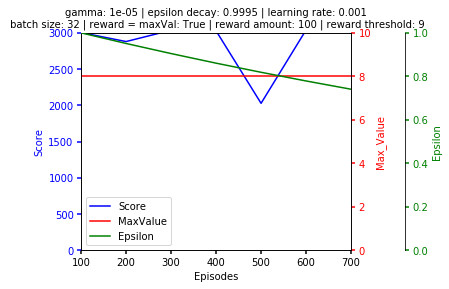

In [27]:
import json
import matplotlib.pyplot as plt
import os
#plotting info from https://matplotlib.org/gallery/ticks_and_spines/multiple_yaxis_with_spines.html


#####SET PARAMETERS HERE######
stepsize = 100
plot_max_instead_of_avg = False
inputname = "test99"
debug = False
#####SET PARAMETERS HERE######

path = os.getcwd()

def plot():
    with open(path + '/data/'+inputname+'output.txt', "r") as infile:
      inputlist = json.load(infile)
      if (debug): print("path is: " + str(path))
      if (debug): print("list is: " + str(inputlist))
      #extract first item from list which is the configuration info

      plottitle = inputlist[0]
      inputlist.pop(0)
      calculate_data(inputlist, plottitle)



def calculate_data(inputlist, plottitle):
  number_of_steps = int(len(inputlist) / stepsize)
  if(debug):print("nr of steps is: " + str(number_of_steps))

  # EPISODES
  episodes_list = []
  for i in range(1, number_of_steps + 1):
    episodes_list.append(i * stepsize);
  if (debug):print("episode list: " + str(episodes_list))

  # Average Score
  avg_score_list = []
  for i in range(0, number_of_steps):
    sum = 0
    for j in range(0, stepsize):
      sum = sum + inputlist[stepsize * i + j][2]
    result = sum / (stepsize)
    avg_score_list.append(result)
  if (debug):print("avg_score_list: " + str(avg_score_list))

  # Average MaxValue
  avg_max_value_list = []
  for i in range(0, number_of_steps):
    sum = 0
    for j in range(0, stepsize):
      sum = sum + inputlist[stepsize * i + j][1]
    result = sum / float(stepsize)
    avg_max_value_list.append(result)
  if (debug):print("avg_max_value_list: " + str(avg_max_value_list))

  # Epsilon
  epsilon_list = []
  for i in range(0, number_of_steps):
    result = inputlist[stepsize * i][3]
    epsilon_list.append(result)
  if (debug):print("epsilon_list: " + str(epsilon_list))

  # MaxScore
  max_score_list = []
  # make now list consisting only of scores
  templist = [i[2] for i in inputlist]
  for i in range(0, number_of_steps):
    result = max(templist[i * stepsize:((i + 1) * stepsize)])
    max_score_list.append(result)
  if (debug):print("max_score: " + str(max_score_list))

  # MaxValue
  max_value_list = []
  # make now list consisting only of scores
  templist_two = [i[1] for i in inputlist]
  for i in range(0, number_of_steps):
    result = max(templist_two[i * stepsize:((i + 1) * stepsize)])
    max_value_list.append(result)
  if (debug):print("max_value_list: " + str(max_value_list))


  if(plot_max_instead_of_avg):
      plot_data(plottitle, max_x=len(inputlist)-(len(inputlist)%stepsize), para_episodes_list=episodes_list, para_value_list=max_value_list, para_score_list=max_score_list, para_epsilon_list=epsilon_list)
  else:
      plot_data(plottitle, max_x=len(inputlist)-(len(inputlist)%stepsize), para_episodes_list=episodes_list, para_value_list=avg_max_value_list, para_score_list=avg_score_list, para_epsilon_list=epsilon_list)


def plot_data(plottitle, max_x, para_episodes_list, para_value_list, para_score_list, para_epsilon_list):
    def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
            sp.set_visible(False)


    fig, host = plt.subplots()
    fig.subplots_adjust(right=0.75)
    par1 = host.twinx()
    par2 = host.twinx()
    par2.spines["right"].set_position(("axes", 1.2))
    make_patch_spines_invisible(par2)
    par2.spines["right"].set_visible(True)

    #Score
    p1, = host.plot(para_episodes_list, para_score_list, "b-", label="Score")
    #MaxValue
    p2, = par1.plot(para_episodes_list, para_value_list, "r-", label="MaxValue")
    #Epsilon
    p3, = par2.plot(para_episodes_list, para_epsilon_list, "g-", label="Epsilon")

    #Episodes
    host.set_xlim(stepsize, max_x)
    #Score
    host.set_ylim(0, 3000)
    #MaxValue
    par1.set_ylim(0, 10)
    #Epsilon
    par2.set_ylim(0, 1)


    host.set_xlabel("Episodes")
    host.set_ylabel("Score")
    par1.set_ylabel("Max_Value")
    par2.set_ylabel("Epsilon")
    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())
    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)
    lines = [p1, p2, p3]
    host.legend(lines, [l.get_label() for l in lines])
    print("this is title"+str(plottitle))
    plt.title(plottitle, fontsize=10)
    plt.show()

plot()